#10.1: Import the libraries and load the data.

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None
from scipy import stats
from scipy.stats import skew, norm
import statsmodels.api as sm
import joblib
import pickle

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

import seaborn as sns
sns.set_theme('paper')
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sns.color_palette()
from IPython.display import display
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go
import plotly.express as px
import plotly.tools as tls
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving KAG_conversion_data.csv to KAG_conversion_data.csv


In [4]:
kag = pd.read_csv('KAG_conversion_data.csv', encoding='Latin-1')
display(kag.head(), kag.tail())

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1


,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
1138,1314410,1178,179977,45-49,F,109,1129773,252,358.189997,13,2
1139,1314411,1178,179978,45-49,F,110,637549,120,173.880003,3,0
1140,1314412,1178,179979,45-49,F,111,151531,28,40.289999,2,0
1141,1314414,1178,179981,45-49,F,113,790253,135,198.710000,8,2
1142,1314415,1178,179982,45-49,F,114,513161,114,165.609999,5,2


Columns: 

1. ad_id: unique ID for each ad.
2. xyz_campaign_id: ID associated with each ad campaign of XYZ company.
3. fb_campaign_id: ID associated with how Facebook tracks each campaign.
4. age: age of the person to whom the ad is shown.
5. gender: gender of the person to whom the add is shown
6. interest: code specifying the category to which the person’s interest belongs as mentioned in their Facebook public profile.
7. Impressions: the number of times the ad was shown.
8. Clicks: number of clicks on for that ad.
9. Spent: Amount paid by company xyz to Facebook, to show that ad.
10. Total_conversion: Total number of people who enquired about the product after seeing the ad.
11. Approved_conversion: Total number of people who bought the product after seeing the ad.

In [5]:
print(f'The dataset has {kag.shape[0]} rows and {kag.shape[1]} columns')

The dataset has 1143 rows and 11 columns


In [6]:
display(kag.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ad_id                1143 non-null   int64  
 1   xyz_campaign_id      1143 non-null   int64  
 2   fb_campaign_id       1143 non-null   int64  
 3   age                  1143 non-null   object 
 4   gender               1143 non-null   object 
 5   interest             1143 non-null   int64  
 6   Impressions          1143 non-null   int64  
 7   Clicks               1143 non-null   int64  
 8   Spent                1143 non-null   float64
 9   Total_Conversion     1143 non-null   int64  
 10  Approved_Conversion  1143 non-null   int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 98.4+ KB


None

In [7]:
display(kag.isna().sum())

ad_id                  0
xyz_campaign_id        0
fb_campaign_id         0
age                    0
gender                 0
interest               0
Impressions            0
Clicks                 0
Spent                  0
Total_Conversion       0
Approved_Conversion    0
dtype: int64

In [8]:
display(kag.describe(include='all').round().T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ad_id,1143,NaN,NaN,NaN,987261,193993,708746,777632,1.12118e+06,1.1218e+06,1.31442e+06
xyz_campaign_id,1143,NaN,NaN,NaN,1067,122,916,936,1178,1178,1178
fb_campaign_id,1143,NaN,NaN,NaN,133784,20500,103916,115716,144549,144658,179982
age,1143,4,30-34,426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,1143,2,M,592,NaN,NaN,NaN,NaN,NaN,NaN,NaN
interest,1143,NaN,NaN,NaN,33,27,2,16,25,31,114
Impressions,1143,NaN,NaN,NaN,186732,312762,87,6504,51509,221769,3.052e+06
Clicks,1143,NaN,NaN,NaN,33,57,0,1,8,38,421
Spent,1143,NaN,NaN,NaN,51,87,0,1,12,60,640
Total_Conversion,1143,NaN,NaN,NaN,3,4,0,1,1,3,60


# 2. Dummy encode any categorical or object values in the data and save the resulting data frame to variable X.

In [9]:
categorical = [col for col in kag.select_dtypes('object').columns]
display(categorical)

['age', 'gender']

In [10]:
X = pd.get_dummies(kag, columns=categorical)
display(X.head(3))

,ad_id,xyz_campaign_id,fb_campaign_id,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,age_30-34,age_35-39,age_40-44,age_45-49,gender_F,gender_M
0,708746,916,103916,15,7350,1,1.43,2,1,1,0,0,0,0,1
1,708749,916,103917,16,17861,2,1.82,2,0,1,0,0,0,0,1
2,708771,916,103920,20,693,0,0.00,1,0,1,0,0,0,0,1


#10.3: Use a heatmap to show the correlation in the data.

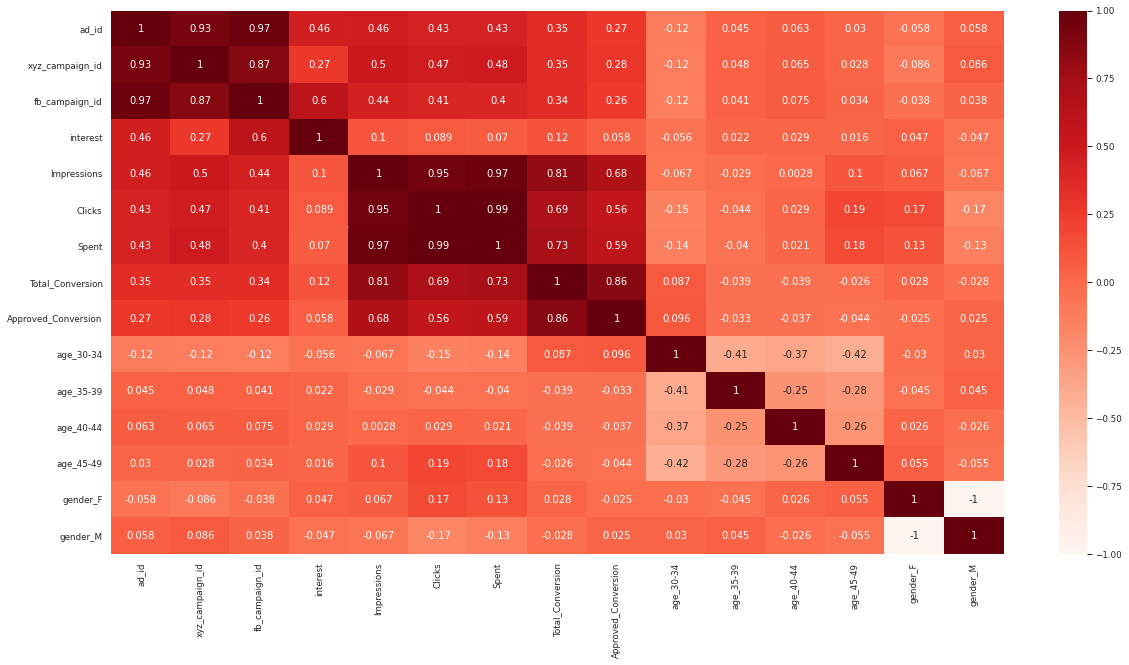

In [11]:
plt.figure(figsize=(20, 10))
sns.heatmap(data=X.corr(), annot=True, cmap='Reds',)

- From this analysis, the total and approved conversions are positively correlated with the 30-34 age group.
- Clicks are positively correlated with age groups 40-44 & 45-49 however their  conversions are negatively correlated suggesting their purchase is lower than the younger age groups.
- Females are much more likely to click on the ad and inquire about the product however males seem to purchase the product more.
- Both campaigns A & B were targeted more towards younger customers due to a positive correlation with ages 30-34 while campaign C was targeted at older customers due to a negative correlation with ages 30-34.


 10.3 a): Drop the first 4 columns in the data frame X.




In [12]:
X = X.drop(columns=X.columns[[0, 1, 2, 3]])
X.head()

,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,age_30-34,age_35-39,age_40-44,age_45-49,gender_F,gender_M
0,7350,1,1.43,2,1,1,0,0,0,0,1
1,17861,2,1.82,2,0,1,0,0,0,0,1
2,693,0,0.00,1,0,1,0,0,0,0,1
3,4259,1,1.25,1,0,1,0,0,0,0,1
4,4133,1,1.29,1,1,1,0,0,0,0,1


10.3 b): Basing your answer on what can be seen in the heat map, why did we drop these columns?
- The values in these features are arbitrary and have no meaning in correlation and do not affect our conclusion.



# 10.4: Using the elbow method: Determine the best number of clusters for the data in the range of 2 to 20.


In [13]:
wcss = []  # distortions
K = range(2, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

10.4 b): Include the graphical plot for the elbow curve.

In [14]:
fig = px.line(x=K, y=wcss, title='Elbow Curve', template='plotly_dark')
fig.update_layout(xaxis_title='Number of Clusters', yaxis_title='Distortions')
fig.update_traces(mode='markers + lines')
fig.show(renderer='colab')

According to the Elbow graph we determine the clusters number as 6. 

# 10.5: Use the value at your elbow point to cluster the values in the data frame X.

In [15]:
kmeans = KMeans(6, random_state=42)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

# 10.6. Use the model to predict the labels from the data and save them to variable y_means.

In [16]:
y_means = kmeans.predict(X)

# 10.7: Add the values in y_means to the original data frame as column ‘Advert_Type’.

In [17]:
kag['Advert_Type'] = y_means
kag.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Advert_Type
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,5
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,5
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,5
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,5
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,5


#10.8: Using any form of distribution plot of your choice and the original data frame, plot 2 graphs that can be used to answer the following:

a) Which advert type lead to the highest and consistent amount of sales by customers of all the age brackets?



In [28]:
kag.groupby(['Advert_Type']).agg({'Approved_Conversion': lambda x: x.sum()}).reset_index()

,Advert_Type,Approved_Conversion
0,0,199
1,1,210
2,2,174
3,3,58
4,4,151
5,5,287


In [27]:
data = kag.groupby(['Advert_Type', 'age']).agg({'Approved_Conversion': lambda x: x.sum()}).reset_index()
data.head()

,Advert_Type,age,Approved_Conversion
0,0,30-34,81
1,0,35-39,59
2,0,40-44,31
3,0,45-49,28
4,1,30-34,107


In [26]:
fig = px.bar(data, x='Advert_Type', y='Approved_Conversion', color='age', template='plotly_dark', barmode='group')
fig.show(renderer='colab')

- According to the above analysis, Advert_Type 5 led to the highest and consistent sales to customers of all age brackets

b): Does the company xyz have gender bias in terms of their ad spending? Are their products gender neutral?

In [32]:
df = kag.groupby(['gender']).agg({'Spent': lambda x: x.sum()}).reset_index()
df

,gender,Spent
0,F,34502.619963
1,M,24202.609995


In [33]:
fig = px.bar(data_frame=df, x='gender', y='Spent', color='gender', template='plotly_dark', )
fig.show(renderer='colab')

- From the above analysis, we can conclude that the xyz company spends slightly more towards ads for products aimed at the female clientele that the male clientele.

#10.9: Perform the same analysis using hierarchical clustering and compare the results in terms of the number of useable clusters.

Text(0, 0.5, 'Euclidean distance')

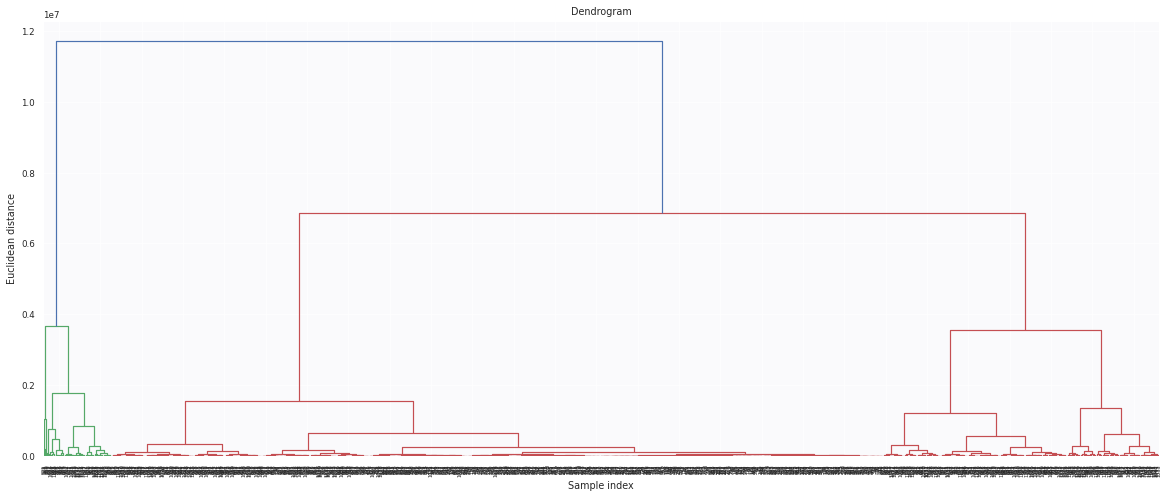

In [35]:
import scipy.cluster.hierarchy as sc

# Plot dendrogram
plt.figure(figsize=(20, 8))  
plt.title("Dendrograms")  

# Create dendrogram
sc.dendrogram(sc.linkage(X, method='ward'))

plt.title('Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')

The above analysis illustrates the presence of 3 clusters when the tree is cut at a Dendrogram distance of 6. The general idea being, all 3 groups of clusters combines at a much higher dendrogram distance and hence can be treated as individual groups for this analysis. 

In [42]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

pred_hc = cluster.fit_predict(X)

In [43]:
kag['Ad_Type_Hc'] = pred_hc
kag.head()

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,Advert_Type,Ad_Type_Hc
0,708746,916,103916,30-34,M,15,7350,1,1.43,2,1,5,2
1,708749,916,103917,30-34,M,16,17861,2,1.82,2,0,5,2
2,708771,916,103920,30-34,M,20,693,0,0.00,1,0,5,2
3,708815,916,103928,30-34,M,28,4259,1,1.25,1,0,5,2
4,708818,916,103928,30-34,M,28,4133,1,1.29,1,1,5,2


In [44]:
kag.groupby(['Ad_Type_Hc']).agg({'Approved_Conversion': lambda x: x.sum()}).reset_index()

,Ad_Type_Hc,Approved_Conversion
0,0,321
1,1,390
2,2,368


In [ ]:
data = kag.groupby(['Ad_Type_Hc', 'age']).agg({'Approved_Conversion': lambda x: x.sum()}).reset_index()

In [46]:
fig = px.bar(data, x='Ad_Type_Hc', y='Approved_Conversion', color='age', template='plotly_dark', barmode='group')
fig.show(renderer='colab')